In [ ]:
import yfinance as yf
import pandas as pd

# Download NVIDIA stock data
data = yf.download('NVDA', start='2015-01-01', end='2025-10-01', interval='1d')

/var/folders/94/18sqr3292qj66m2k622fh4580000gn/T/ipykernel_16842/2422928320.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('NVDA', start='2015-01-01', end='2025-10-01', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [2]:
df = pd.DataFrame(data=data.values, columns=['Close', 'High', 'Low', 'Open', 'Volume'])
df.insert(0, 'Date', data.index)
df

,Date,Close,High,Low,Open,Volume
0,2015-01-02,0.483038,0.486638,0.475360,0.483038,113680000.0
1,2015-01-05,0.474880,0.484478,0.472720,0.483038,197952000.0
2,2015-01-06,0.460482,0.476079,0.460002,0.475600,197764000.0
3,2015-01-07,0.459282,0.467921,0.457843,0.463842,321808000.0
4,2015-01-08,0.476559,0.479439,0.464321,0.464561,283780000.0
...,...,...,...,...,...,...
2697,2025-09-24,176.970001,179.779999,175.399994,179.770004,143564100.0
2698,2025-09-25,177.690002,180.259995,173.130005,174.479996,191586700.0
2699,2025-09-26,178.190002,179.770004,174.929993,178.169998,148573700.0
2700,2025-09-29,181.850006,184.000000,180.320007,180.429993,193063500.0


In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Prepare the stock data for LSTM by converting dates to proper datetime format and scaling numerical features. Scaling is important because LSTM models perform better when input values are normalized.


In [4]:
train_dates = pd.to_datetime(df['Date'])

train_cols = ['Close', 'High', 'Low', 'Open', 'Volume']

scaler = StandardScaler()
scaler = scaler.fit(df[train_cols]) # we need this for inverse transform later
df_scaled = scaler.transform(df[train_cols])

Prepare the input (`X_train`) and output (`y_train`) for the LSTM model.

- `n_past` defines how many past days the model will use to make a prediction.
- `n_features` represents the number of days we want to predict into the future.


In [5]:
X_train = []
y_train = []
n_features = 1
n_past = 14

Reformat the data to make it suitable for the input:

- LSTM expects input in the shape **(samples, timesteps, features)**.
- For each step, we take the past `n_past` days as input (`X_train`) and predict the future `n_features` day(s) of the 'Open' price (`y_train`).


In [6]:
for i in range(n_past, len(df_scaled) - n_features + 1):
    X_train.append(df_scaled[i - n_past:i, 0: df_scaled.shape[1]])
    y_train.append(df_scaled[i + n_features - 1:i + n_features, 3])  # Predicting 'Open' price

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2688, 14, 5) (2688, 1)


Define an LSTM autoencoder model for time series prediction:

- The model is built using **Keras Sequential API**.
- **First LSTM layer**: 64 units, `tanh` activation, returns sequences for the next LSTM layer.
- **Second LSTM layer**: 32 units, outputs the final hidden state.
- **Dropout layer**: Prevents overfitting by randomly ignoring 20% of neurons during training.
- **Dense layer**: Outputs the predicted value(s) of the 'Open' price.
- **Compile**: Using `adam` optimizer and mean squared error (`mse`) loss function.
- `model.summary()` prints the architecture and number of parameters.


In [8]:
model = Sequential()

model.add(
    LSTM(64,
         activation='tanh',
         recurrent_activation='sigmoid',
         input_shape=(X_train.shape[1], X_train.shape[2]),
         return_sequences=True)
         )

model.add(
    LSTM(32,
         activation='tanh',
         recurrent_activation='sigmoid',
         return_sequences=False)
         )

model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Train the LSTM model on the prepared data:

- `X_train` and `y_train` are the input and target sequences.
- `epochs=50`: The model will go through the entire dataset 50 times.
- `batch_size=32`: Number of samples processed before updating the model’s weights.
- `validation_split=0.1`: 10% of the data is used to evaluate the model during training.
- `verbose=1`: Displays the training progress for each epoch.


In [9]:
# fit the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0718 - val_loss: 0.1680
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.1430
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.1709
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0691
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.1319
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0687
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0730
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0577
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0365
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0719
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.1501
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

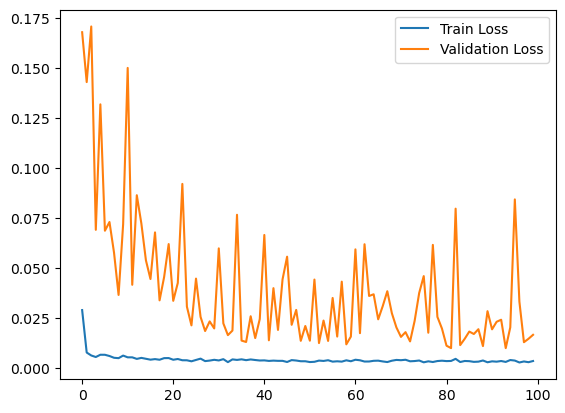

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Generate the future dates for prediction while considering only US business days:

- Import libraries to handle US federal holidays and business days.
- `n_past` specifies how many past days we look back for predictions.
- `n_days_for_prediction` is the number of future days we want to predict.
- `pd.date_range` with `CustomBusinessDay` ensures that the predicted dates skip weekends and US holidays.
- `predict_period_dates` contains the list of dates corresponding to the predictions.


In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

n_past = 15
n_days_for_prediction = 14

predict_period_dates = pd.date_range(
    start=list(train_dates)[-n_past],
    periods=n_days_for_prediction,
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
).tolist()
predict_period_dates

[Timestamp('2025-09-10 00:00:00', freq='C'),
 Timestamp('2025-09-11 00:00:00', freq='C'),
 Timestamp('2025-09-12 00:00:00', freq='C'),
 Timestamp('2025-09-15 00:00:00', freq='C'),
 Timestamp('2025-09-16 00:00:00', freq='C'),
 Timestamp('2025-09-17 00:00:00', freq='C'),
 Timestamp('2025-09-18 00:00:00', freq='C'),
 Timestamp('2025-09-19 00:00:00', freq='C'),
 Timestamp('2025-09-22 00:00:00', freq='C'),
 Timestamp('2025-09-23 00:00:00', freq='C'),
 Timestamp('2025-09-24 00:00:00', freq='C'),
 Timestamp('2025-09-25 00:00:00', freq='C'),
 Timestamp('2025-09-26 00:00:00', freq='C'),
 Timestamp('2025-09-29 00:00:00', freq='C')]

In [12]:
# Make predictions
prediction = model.predict(X_train[-n_days_for_prediction:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Rescale the predictions back to the original stock price range:

- The scaler was fitted on **5 features**, so inverse transformation expects the same number of columns.
- `np.repeat` duplicates the predictions across 5 columns temporarily.
- `scaler.inverse_transform` converts the normalized values back to the original scale.
- We only keep the first column (the 'Open' price) as our final predicted values (`y_pred_future`).


In [13]:
prediction_copies = np.repeat(prediction, df_scaled.shape[1], axis=1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]
y_pred_future

array([170.20425, 165.36333, 167.61821, 166.33395, 165.35822, 160.61212,
       168.8389 , 164.85641, 170.66518, 165.38971, 167.17342, 166.25119,
       167.5829 , 171.32812], dtype=float32)

In [14]:
df_forecast = pd.DataFrame({
    'Date': pd.to_datetime(predict_period_dates),
    'Predicted_Open': y_pred_future
})
df_forecast

,Date,Predicted_Open
0,2025-09-10,170.204254
1,2025-09-11,165.363327
2,2025-09-12,167.618210
3,2025-09-15,166.333954
4,2025-09-16,165.358215
5,2025-09-17,160.612122
6,2025-09-18,168.838898
7,2025-09-19,164.856415
8,2025-09-22,170.665176
9,2025-09-23,165.389709


In [15]:
# Extracting original 'Open' prices for the forecasted dates for comparison
df_original = df.loc[(df['Date'] >= '2025-09-10') & (df['Date'] <= '2025-09-29'), ['Date', 'Open'] ]

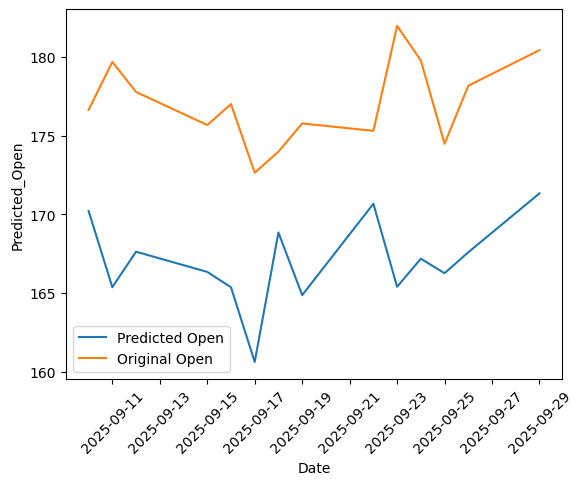

In [16]:
sns.lineplot(data=df_forecast, x='Date', y='Predicted_Open', label='Predicted Open')
sns.lineplot(data=df_original, x='Date', y='Open', label='Original Open')
plt.xticks(rotation=45)
plt.show()